This is going to be an analysis using MCMC to analyze the behavioral data from the RDK with priors task. In this version of the task there is a prior in blocks that changes over the course of the day. We assume that the behavioral data follows a sigmoid function:

$$ prob_R = \frac{1}{1+exp(-4a(x-b))} $$

where $b$ defines the threshold at which the rat gets 50% of trials correct, and $a$ describes the slope of the psychophysical curve at threshold. We want to ask if and where there are any changes in the parameters of the psychophysical curves, to hopefully see them occur at the prior block transitions.



In [1]:
import pymc as pm
import numpy as np
import scipy.io as sio
import glob
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import cycle


%matplotlib inline

color_cycle = cycle(['g', 'b', 'c', 'm', 'y', 'k'])

In [3]:
# this is a function to load the mat behavioral data files to a panda format
def load_RDK_data_from_mat_to_pandas(filename):
    mat = sio.loadmat(filename)
    mat = mat['temp_obj'][0]
    field_names = mat.dtype.names
    data = mat[0]
    data_dict = dict(zip(field_names,data))
    for key in data_dict:
        data_dict[key] = data_dict[key].squeeze()

    return data_dict

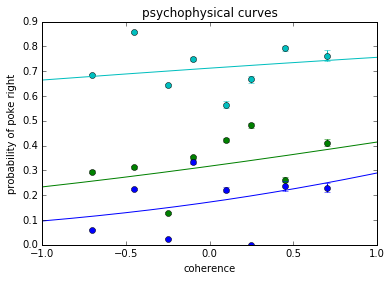

In [4]:
# load data from a certain date
rat_name = 'miley0'
data = load_RDK_data_from_mat_to_pandas('/home/adam/Documents/DATA/RDK/Behavior_1/Adam20170516/'+rat_name+'_session1.spd')
data = pd.DataFrame.from_dict(data)
data.index.name = 'trial'

# this makes psychophysical curves
plt.figure()
plt.title('psychophysical curves')
plt.xlabel('coherence')
plt.ylabel('probability of poke right')
for p in data.prior_right.unique():
    cc = color_cycle.next()
    
    data_p = data.loc[lambda x: x.prior_right == p] # pick out data for the given prior
    coherence_means = data_p.groupby(['coherence'],as_index=False).response_right.mean()
    
    # std of estimation for a binary variable is sqrt(p(1-p)/n)
    yerrors = np.ravel(coherence_means.apply(lambda x: x*(1-x)).response_right)
    yerrors = yerrors/np.ravel(data_p['coherence'].value_counts())
    plt.errorbar(coherence_means.coherence,coherence_means.response_right,yerr = yerrors,fmt='o',color=cc)
    
    # logistic regression to fit psychophysical curve
    log_model = linear_model.LogisticRegression(C=1e20,max_iter=100,penalty='l2')
    log_model.fit(X = data_p.coherence.reshape(data_p.coherence.count(),1), y = np.ravel(data_p.response_right))
    
    # plot values psych curves
    x_val = np.linspace(-1,1,200).reshape(200,1)
    plt.plot(x_val,log_model.predict_proba(x_val)[:,1],color=cc)

In [5]:
# this runs mcmc on the data, with just a normal psychophysical curve

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);

# priors on the slope and intercept
slope_ = pm.Uniform('a',-10,10)
intercept_ = pm.Uniform('b',-1,1)

# this function describes the psychophysical curve. it is deterministic because 
@pm.deterministic
def coin_probs_over_time(s_ = slope_, i_ = intercept_, uc = unique_coherences,c = coherences):
    out = np.zeros(len(c))
    for k in range(uc.size):       
        out[np.where(c==uc[k])]=1/( 1+math.exp(-4*s_*(uc[k]- i_)) )
    return out

# in our graphical model we define our observation (the vector describing if the rat nosepokes rightward)
# as being generated by a bernoulli distribution, with probability given by the psychophysical curve which
# is defined in coin_probs_over_time
observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)


# start sampling
M = pm.Model([slope_,intercept_, coin_probs_over_time,observation])
mcmc = pm.MCMC(M)
mcmc.sample(40000,10000)
    
    
    

 [-----------------100%-----------------] 40000 of 40000 complete in 19.0 sec

(-10, 10)

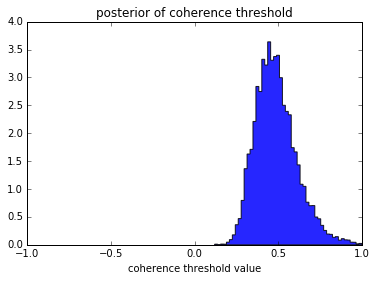

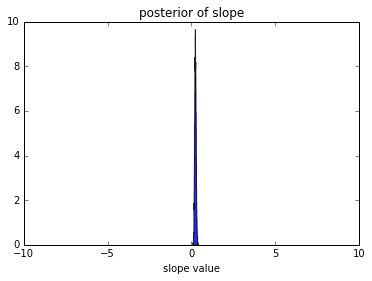

In [6]:
intercept_samples = mcmc.trace('b')[:]
slope_samples = mcmc.trace('a')[:]

plt.hist(intercept_samples,histtype='stepfilled',bins=50,alpha = 0.85,normed=True)
plt.xlabel('coherence threshold value')
plt.title('posterior of coherence threshold')
plt.xlim([-1,1])
plt.figure()
plt.hist(slope_samples,histtype='stepfilled',bins=50,alpha = 0.85,normed=True)
plt.xlabel('slope value')
plt.title('posterior of slope')
plt.xlim([-10,10])

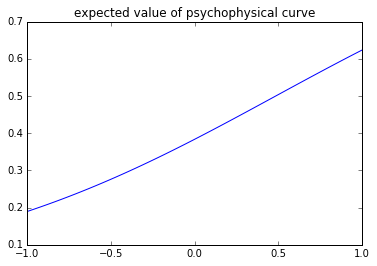

In [827]:
expected_i = sum(intercept_samples)/len(intercept_samples)
expected_s = sum(slope_samples)/len(slope_samples)

x_vals = np.linspace(-1,1)

plt.plot(x_vals,1/( 1+np.exp(-4*expected_s*(x_vals- expected_i))))
plt.title('expected value of psychophysical curve')

In [8]:
# this runs mcmc on the data with a shift in activity

response_data = np.ravel(data.response_right)
coherences = np.ravel(data.coherence)
unique_coherences = np.unique(coherences);

num_tau = 14

tau_tup = ()

ll, uu = 0, len(response_data)-num_tau


for k in range(num_tau):
    tau_tup= tau_tup + (pm.DiscreteUniform('tau'+str(k),lower=ll,upper=uu,value=50*k),)
    ll,uu = tau_tup[k],uu+1
tau_tup  = tau_tup + (len(response_data),)
tau_tup = tau_tup + (10,)



slope_tup = ()
threshold_tup = ()
for k in range(num_tau+1):
    slope_tup = slope_tup + (pm.Uniform('slope'+str(k),-1,1),)
    threshold_tup = threshold_tup + (pm.Uniform('threshold'+str(k),-1,1,value = 0),)


@pm.deterministic
def coin_probs_over_time(s_ = slope_tup, thresh_=threshold_tup,tau_ = tau_tup, uc = unique_coherences,c = coherences):
    out = np.zeros(len(c))
    
    for k in range(uc.size):
        ll,uu = 0,tau_tup[0]
        for r in range(num_tau+1):

            rr = range(ll,uu)
            these_c = np.ravel(np.where(c==uc[k]))
            
            these_c = list(set(these_c).intersection(set(rr)))
            out[these_c] = 1/( 1+math.exp(-4*s_[r]*(uc[k]- thresh_[r])) )

            
            ll,uu=uu,tau_tup[r+1]
            
    return out

observation = pm.Bernoulli("obs",coin_probs_over_time,value=response_data,observed=True)



M = pm.Model(list(tau_tup)[0:num_tau]+list(slope_tup)+list(threshold_tup)+[coin_probs_over_time,observation])
mcmc = pm.MCMC(M)
mcmc.sample(40000,10000,5)
    
    

 [                  0%                  ] 192 of 40000 complete in 34.1 secHalting at iteration  192  of  40000


In [7]:
intercept_samples = mcmc.trace('tau10')[:]
slope_samples = mcmc.trace('tau8')[:]

plt.hist(intercept_samples,histtype='stepfilled',bins=100,alpha = 0.85,normed=True)
plt.xlabel('coherence threshold value')
plt.title('posterior of tau10')
#plt.xlim([-1,1])
plt.figure()
plt.hist(slope_samples,histtype='stepfilled',bins=100,alpha = 0.85,normed=True)
plt.xlabel('slope value')
plt.title('posterior of tau8')
#plt.xlim([-10,10])

KeyError: 'tau10'

In [9]:
list(tau_tup)[0:num_tau]+list(slope_tup)


[<pymc.distributions.DiscreteUniform 'tau0' at 0x7fb98004b890>,
 <pymc.distributions.DiscreteUniform 'tau1' at 0x7fb98004b810>,
 <pymc.distributions.DiscreteUniform 'tau2' at 0x7fb98004b8d0>,
 <pymc.distributions.DiscreteUniform 'tau3' at 0x7fb98004b910>,
 <pymc.distributions.DiscreteUniform 'tau4' at 0x7fb98004b950>,
 <pymc.distributions.DiscreteUniform 'tau5' at 0x7fb98004b990>,
 <pymc.distributions.DiscreteUniform 'tau6' at 0x7fb98004b9d0>,
 <pymc.distributions.DiscreteUniform 'tau7' at 0x7fb98004ba10>,
 <pymc.distributions.DiscreteUniform 'tau8' at 0x7fb98004ba50>,
 <pymc.distributions.DiscreteUniform 'tau9' at 0x7fb98004ba90>,
 <pymc.distributions.DiscreteUniform 'tau10' at 0x7fb98004bad0>,
 <pymc.distributions.DiscreteUniform 'tau11' at 0x7fb98004bb10>,
 <pymc.distributions.DiscreteUniform 'tau12' at 0x7fb98004bb50>,
 <pymc.distributions.DiscreteUniform 'tau13' at 0x7fb98004bb90>,
 <pymc.distributions.Uniform 'slope0' at 0x7fb98004bbd0>,
 <pymc.distributions.Uniform 'slope1' at 0

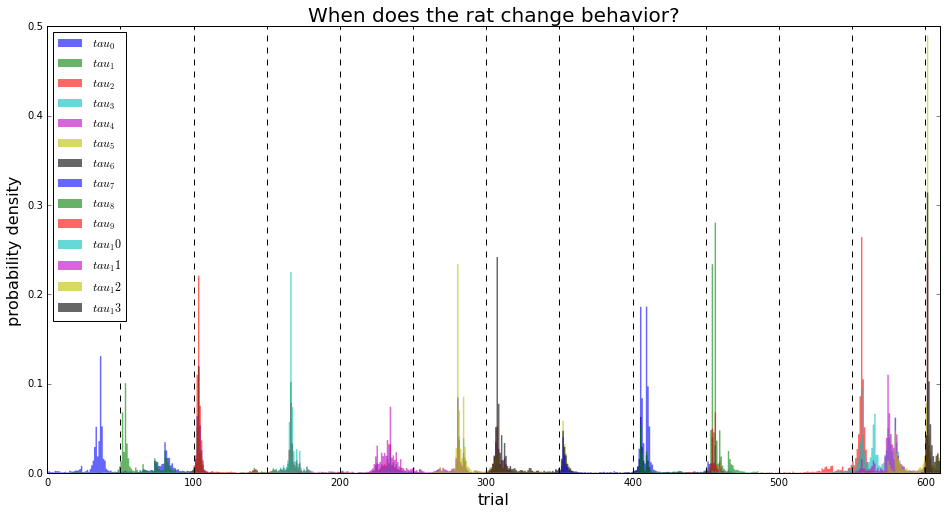

In [109]:
plt.figure(figsize=(16,8))
for i in range(14):
    to_plot = mcmc.trace('tau'+str(i))[:]
    plt.hist(to_plot,histtype='stepfilled',bins=range(0,620),alpha = 0.6,label='$ tau _'+str(i)+'$',linewidth = 0,normed = True)
    plt.plot((50+i*50,50+i*50),(0,0.5),'--k')
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)
plt.xlim(0,610)
plt.title('When does the rat change behavior?',fontsize=20)
plt.savefig('miley0_20170516.pdf')



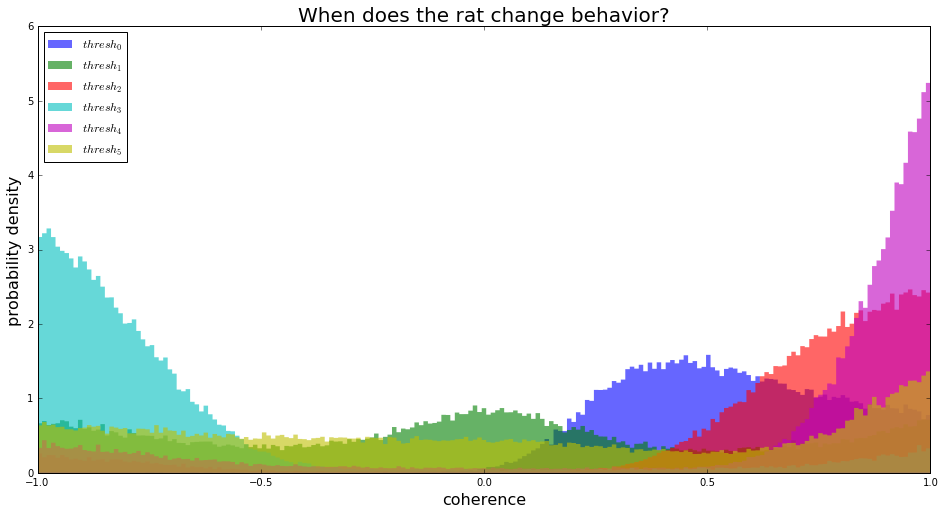

In [86]:
plt.figure(figsize=(16,8))
for i in range(6):
    to_plot = mcmc.trace('threshold'+str(i))[:]
    plt.hist(to_plot,histtype='stepfilled',bins=np.linspace(-1,1,200),alpha = 0.6,label='$ thresh _'+str(i)+'$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('coherence',fontsize = 16)
plt.title('When does the rat change behavior?',fontsize=20)

In [91]:
plt.figure(figsize=(16,8))
for i in range(7):
    to_plot = mcmc.trace('tau'+str(i))[:,0]
    plt.hist(to_plot,histtype='stepfilled',bins=range(0,620),alpha = 0.6,label='$ tau _'+str(i)+'$',linewidth = 0,normed = True)
plt.legend(loc='upper left')
plt.ylabel('probability density',fontsize=16)
plt.xlabel('trial',fontsize = 16)
plt.title('When does the rat change behavior?',fontsize=20)


IndexError: too many indices for array

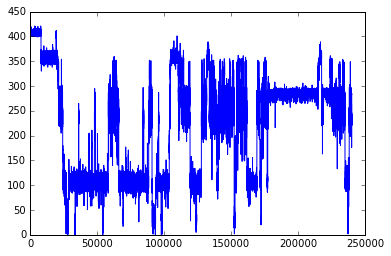

In [97]:
to_plot = mcmc.trace('tau'+str(0))[:]
plt.plot(to_plot)

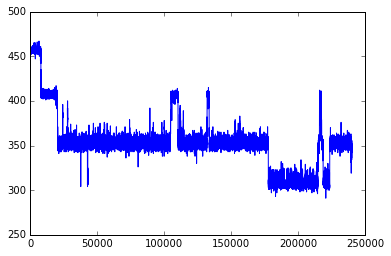

In [95]:
plt.plot(to_plot)

In [98]:
std_trace = mcmc.trace('stds')[:]

KeyError: 'stds'